<a href="https://www.kaggle.com/code/ravaghi/mental-health-prediction-1st-place-solution?scriptVersionId=210551194" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
!pip install -q autogluon.tabular ray==2.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import glob

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e11/train.csv'
    test_path = '/kaggle/input/playground-series-s4e11/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e11/sample_submission.csv'
    
    oof_path = '/kaggle/input/depression-prediction-oof-files'
    
    target = 'Depression'
    n_folds = 5
    seed = 42
    
    time_limit = 3600 * 1

# Loading OOF Files

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [5]:
def get_data(path):
    oof_pred_probs_files = glob.glob(f'{path}/*_oof_pred_probs_*.pkl')
    test_pred_probs_files = glob.glob(f'{path}/*_test_pred_probs_*.pkl')

    oof_pred_probs = pickle.load(open(oof_pred_probs_files[0], 'rb'))
    test_pred_probs = pickle.load(open(test_pred_probs_files[0], 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = accuracy_score(y_val, y_pred_probs.round())
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [6]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [7]:
model_paths = glob.glob(f'{CFG.oof_path}/*')
for model_path in model_paths:
    model_name = model_path.split('/')[-1]
    oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(model_path)

# Creating datasets for training and inference

In [8]:
train = pd.DataFrame(oof_pred_probs)
train[CFG.target] = y

test = pd.DataFrame(test_pred_probs)

In [9]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [10]:
predictor = TabularPredictor(
    problem_type='binary',
    eval_metric='accuracy',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241201_015353"


In [11]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets='experimental_quality'
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.01 GB / 31.35 GB (95.7%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['experimental_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect 

In [12]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,0.941450,accuracy,217.385009,2104.284806,1.285850,44.558405,2,True,9
1,WeightedEnsemble_L3,0.941450,accuracy,217.401486,2108.097862,0.016477,3.813056,3,True,11
2,LightGBMXT_BAG_L2,0.941386,accuracy,218.508176,2101.757647,2.409017,42.031246,2,True,8
3,WeightedEnsemble_L2,0.941286,accuracy,13.798301,1040.621144,0.014353,1.989642,2,True,7
4,LightGBM_BAG_L1,0.941258,accuracy,1.622875,48.494762,1.622875,48.494762,1,True,4
5,LightGBMXT_BAG_L1,0.941038,accuracy,1.623224,34.221700,1.623224,34.221700,1,True,3
6,RandomForestEntr_BAG_L1,0.940810,accuracy,10.064111,934.890815,10.064111,934.890815,1,True,6
7,RandomForestGini_BAG_L2,0.940775,accuracy,227.896529,3008.592901,11.797370,948.866500,2,True,10
8,RandomForestGini_BAG_L1,0.940739,accuracy,12.161072,990.136740,12.161072,990.136740,1,True,5
9,KNeighborsUnif_BAG_L1,0.934584,accuracy,94.690846,25.822715,94.690846,25.822715,1,True,1


# Visualizing the ensemble weights

In [13]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

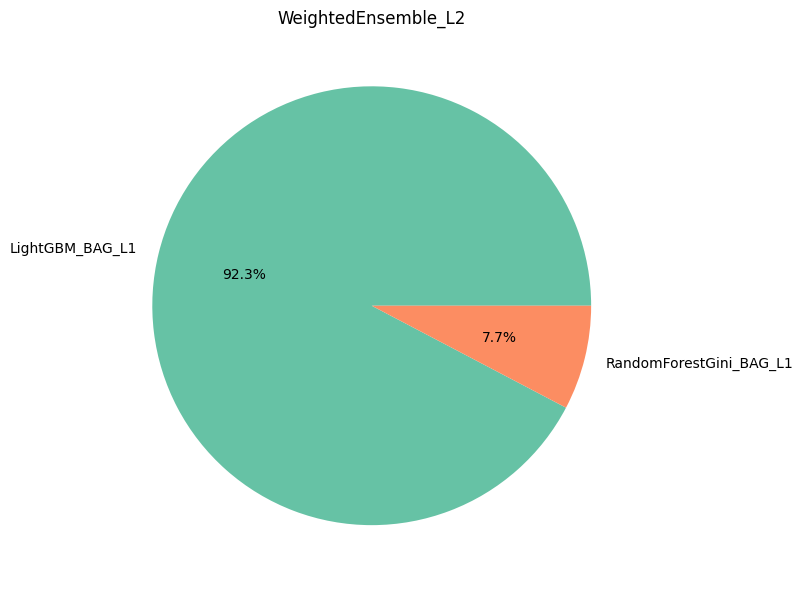

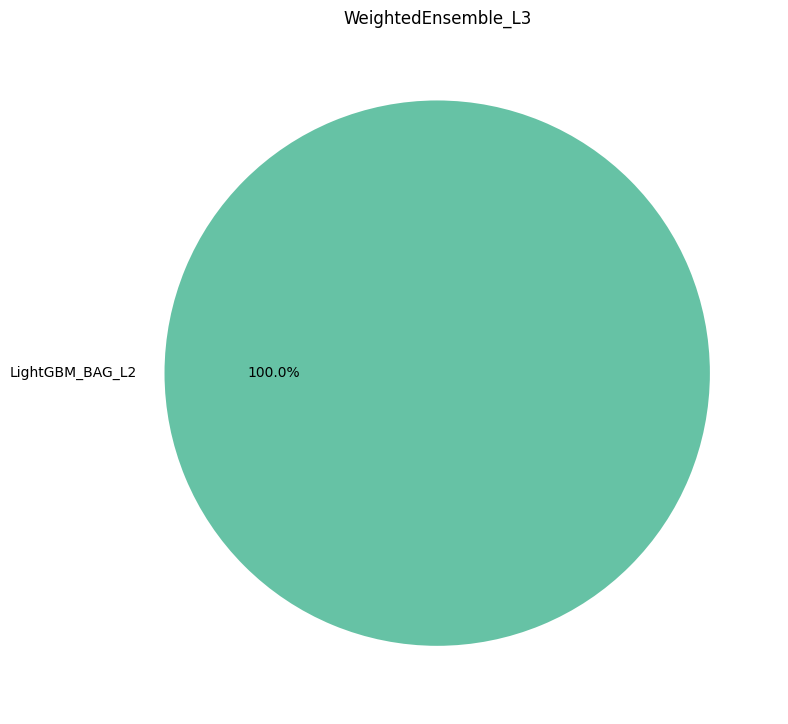

In [14]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Visualizing the results

In [15]:
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
        fold_score = accuracy_score(train.loc[val_index, CFG.target], model_oof_pred_probs[val_index].round())
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

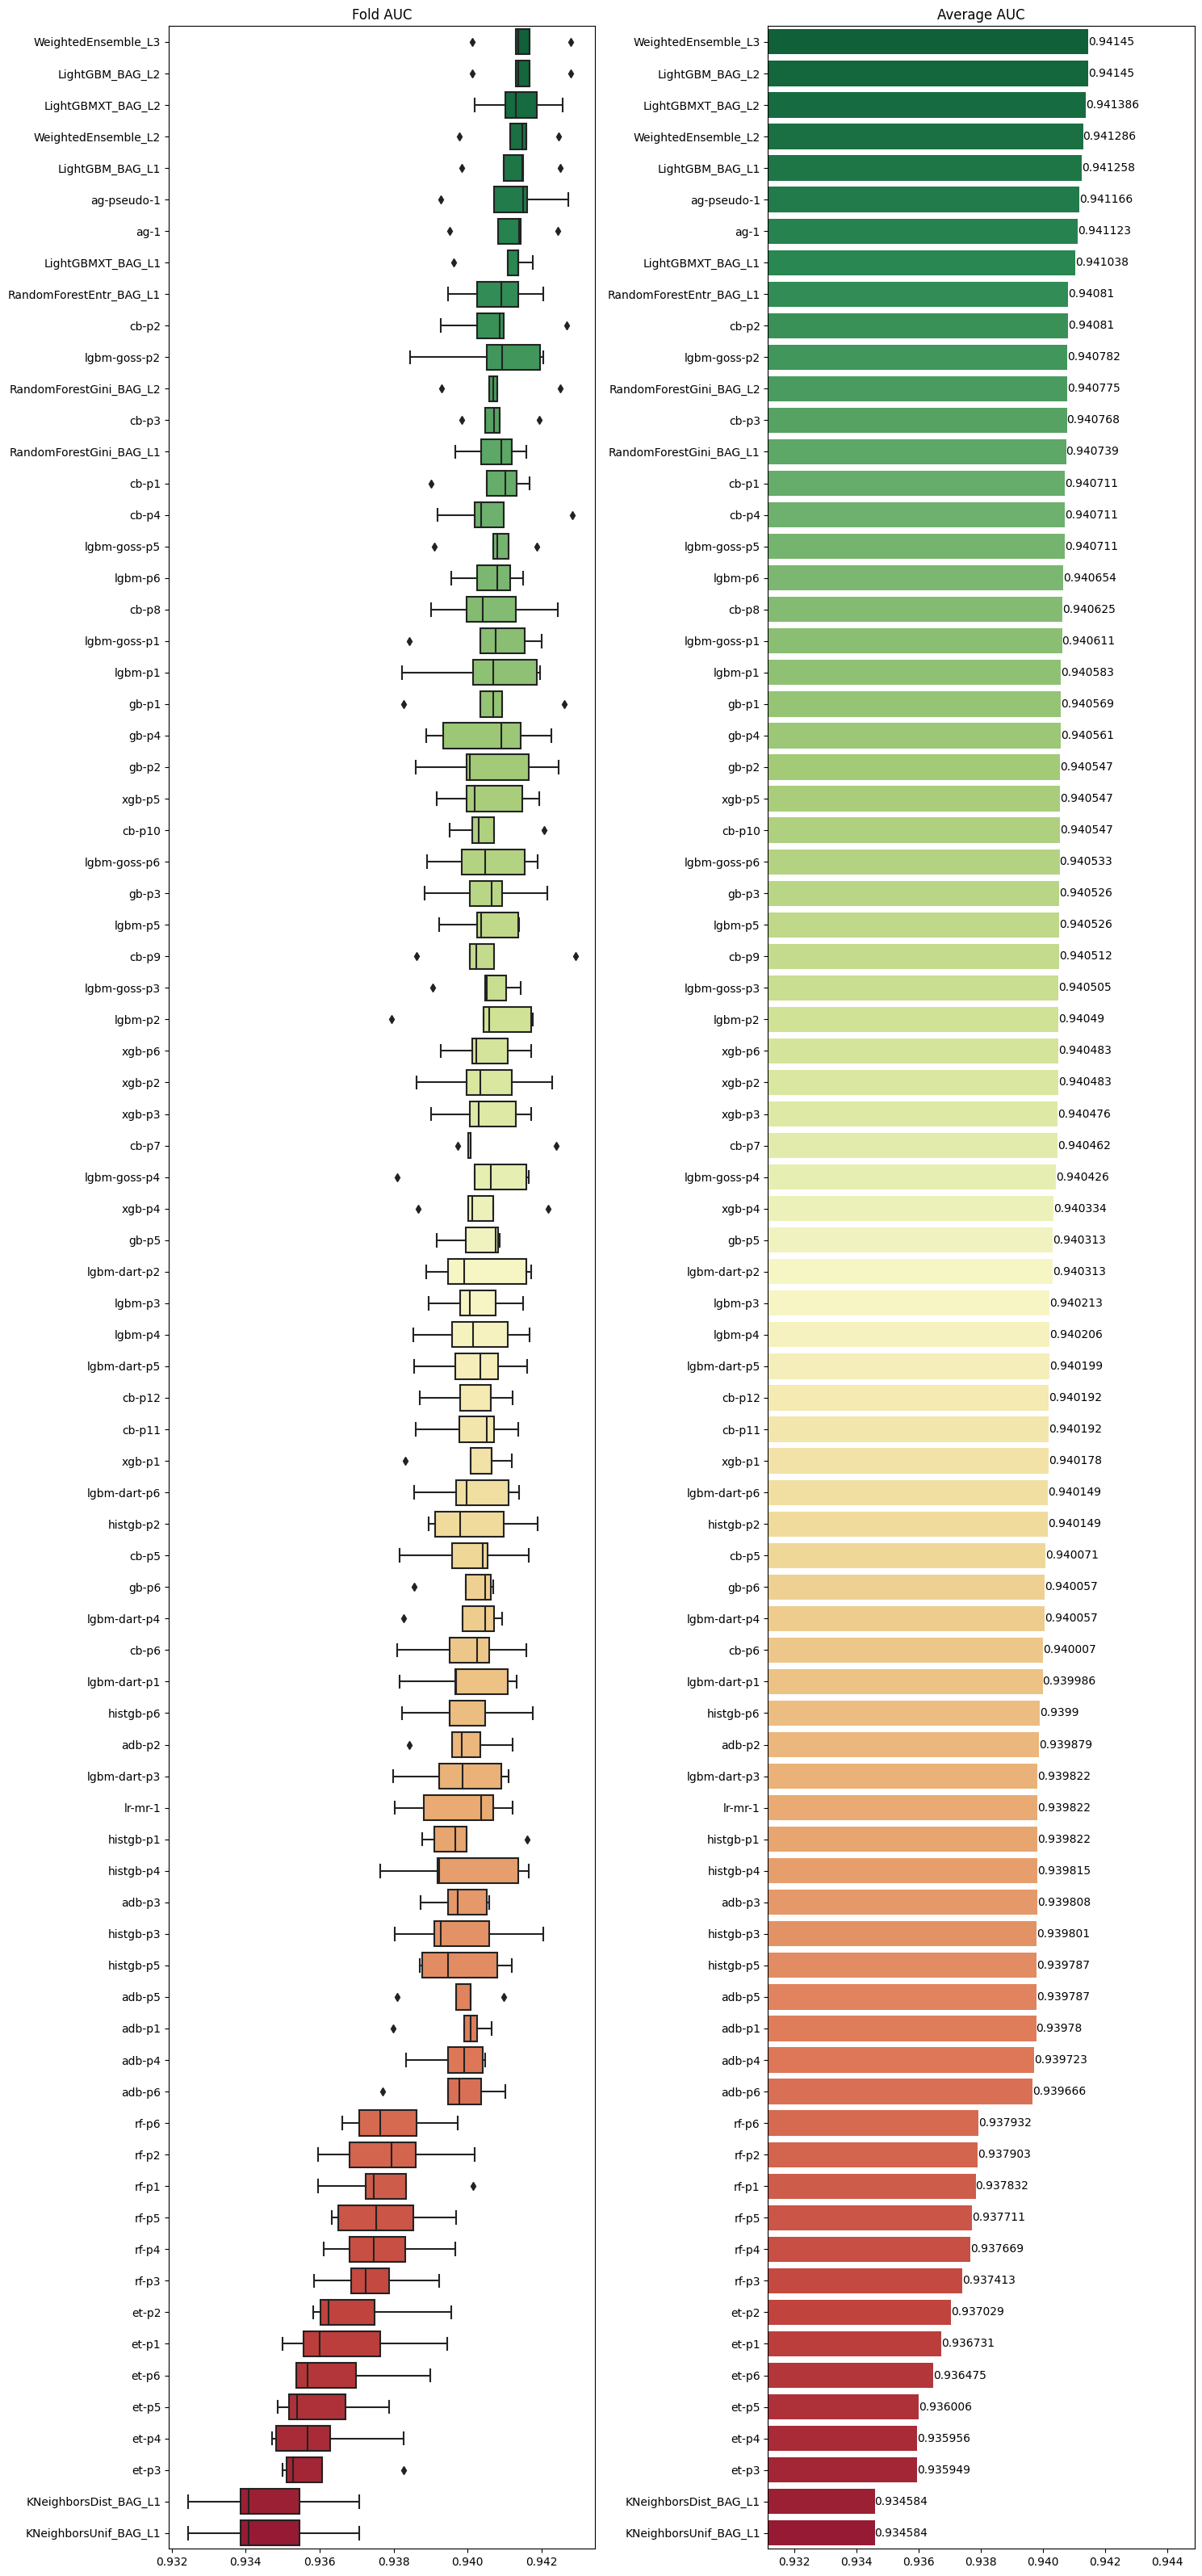

In [16]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

# Creating a submission file

In [17]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = predictor.predict(test).values
sub.to_csv(f'sub_autogluon_{np.mean(scores[predictor.model_best]):.6f}.csv', index=False)

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on

In [18]:
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


In [19]:
shutil.rmtree("AutogluonModels")